In [7]:
%pip install git+http://github.com/yfukai/m2stitch@update_python_version

  Cloning http://github.com/yfukai/m2stitch (to revision update_python_version) to /private/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/pip-req-build-q8y4vh11
  Running command git clone --filter=blob:none --quiet http://github.com/yfukai/m2stitch /private/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/pip-req-build-q8y4vh11
  Running command git checkout -b update_python_version --track origin/update_python_version
  Switched to a new branch 'update_python_version'
  Branch 'update_python_version' set up to track remote branch 'update_python_version' from 'origin'.
  Resolved http://github.com/yfukai/m2stitch to commit 7a4fadff641f07ecd8c18673a132c3cdf378b5ca
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [21]:
import basicpy
import numpy as np
from matplotlib import pyplot as plt
import m2stitch

plt.rcParams["font.family"] = "sans-serif"

In [9]:
data = np.array(list(basicpy.datasets.fetch("wsi_brain", original=True)))

In [10]:
b = basicpy.BaSiC(get_darkfield=True)

In [11]:
b.autotune(data)

[0] fit_and_calc_entropy (Hill Climbing):  25%|──        | 25/100 [04:18<08:10,  6.54s/it, best_iter=0, best_pos=[10 11  7], best_score=-7.200556439000513]Reweighting did not converge.
Single-step optimization did not converge at the last reweighting step.
[0] fit_and_calc_entropy (Hill Climbing):  56%|─────     | 56/100 [08:37<06:46,  9.24s/it, best_iter=0, best_pos=[11 10  1], best_score=-7.188769868046083]



Results: 'fit_and_calc_entropy'  
   Best score: -7.188769868046083  
   Best parameter set:
      'smoothness_flatfield'  : 1.3894954943731375  
      'smoothness_darkfield'  : 0.3727593720314938  
      'sparse_cost_darkfield' : 0.001  
   Best iteration: 0  
 
   Random seed: 1550575904  
 
   Evaluation time   : 517.3389132022858 sec    [100.0 %]
   Optimization time : 0.012676477432250977 sec    [0.0 %]
   Iteration time    : 517.351589679718 sec    [5.17 sec/iter]
 


In [13]:
b.save_model("model", overwrite=True)

In [14]:
images = b.fit_transform(data)

In [15]:
images.shape

(63, 512, 512)

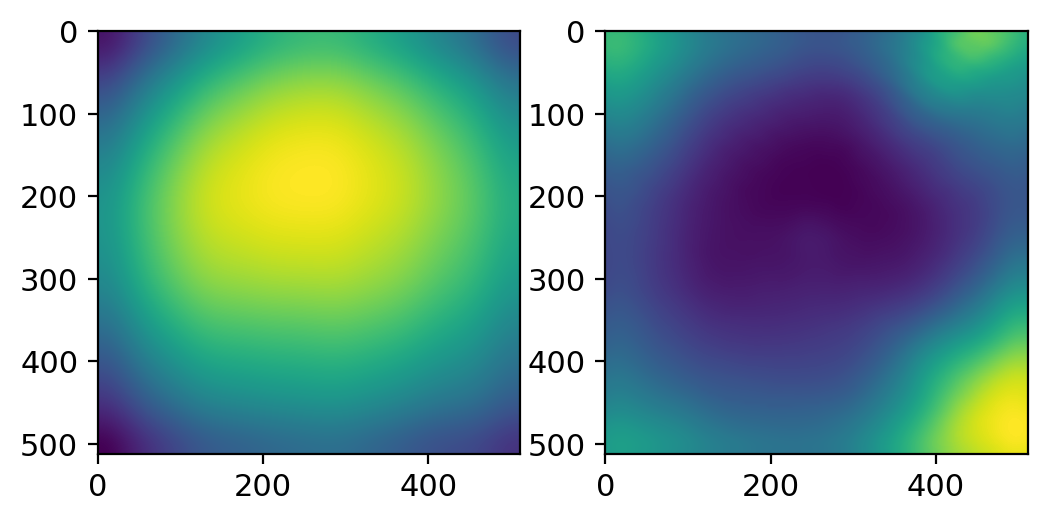

In [22]:
plt.subplot(121)
plt.imshow(b.flatfield)
plt.subplot(122)
plt.imshow(b.darkfield)

In [23]:
images.shape

(63, 512, 512)

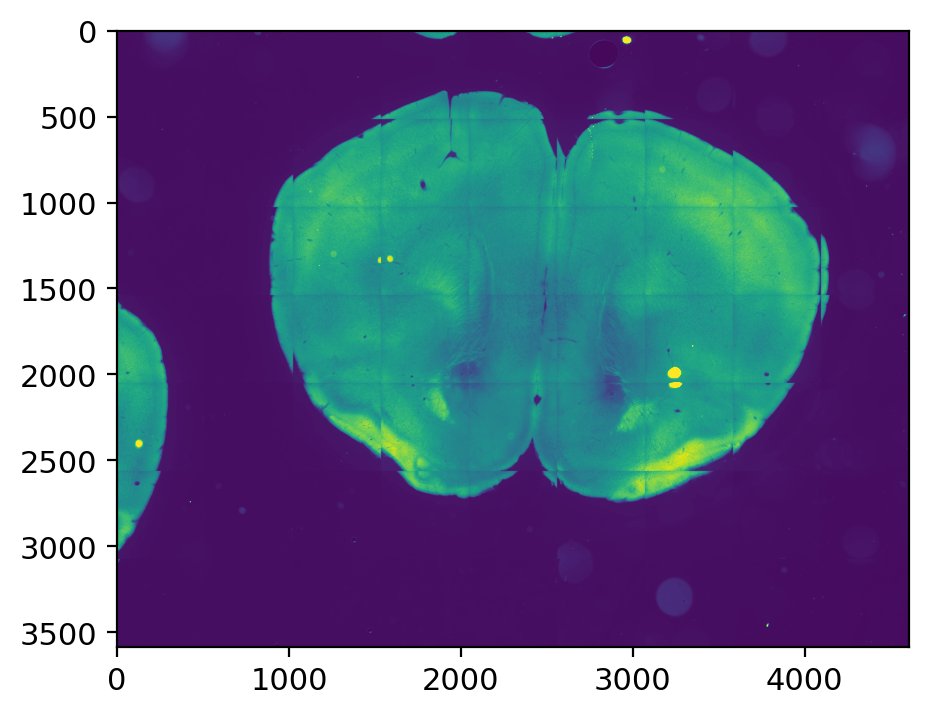

In [24]:
position_indices = []
for i in range(7):
    xpos = range(9) if i % 2 == 1 else range(8, -1, -1)
    for j in xpos:
        position_indices.append((i, j))
stitched_image = np.zeros((7 * images.shape[1], 9 * images.shape[2]))
for im, pos in zip(images, position_indices):
    i, j = pos
    stitched_image[
        i * images.shape[1] : (i + 1) * images.shape[1],
        j * images.shape[2] : (j + 1) * images.shape[2],
    ] = im
plt.imshow(stitched_image, vmax=10000)

In [19]:
result_df, params = m2stitch.stitch_images(
    images,
    position_indices=position_indices,
    ncc_threshold=0.1,
    row_col_transpose=False,
)

100%|██████████| 63/63 [00:08<00:00,  7.62it/s]
/Users/fukai/.pyenv/versions/miniforge3-4.14.0-2/envs/basicpy/lib/python3.11/site-packages/m2stitch/_stage_model.py:133: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  grid.loc[grp.index, "left_valid3"] = False
/Users/fukai/.pyenv/versions/miniforge3-4.14.0-2/envs/basicpy/lib/python3.11/site-packages/m2stitch/_stage_model.py:145: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  grid.loc[grp.index, "top_valid3"] = False
100%|██████████| 63/63 [00:00<00:00, 511.26it/s]


868.5


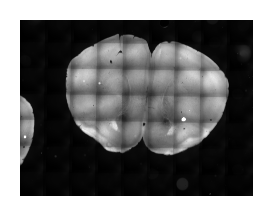

953.8702044677734


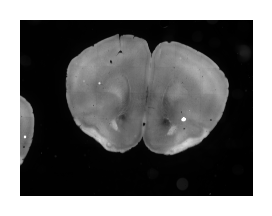

In [25]:
for name, _images in zip(["uncorrected", "corrected"], [data, images]):
    stitched_image = np.zeros(
        (
            result_df["y_pos"].max() + images.shape[1],
            result_df["x_pos"].max() + images.shape[2],
        )
    )
    image_count = np.zeros_like(stitched_image, dtype=np.int16)
    for j, (_, row) in enumerate(result_df.iterrows()):
        im = _images[j]
        window = (
            slice(row["y_pos"], row["y_pos"] + images.shape[1]),
            slice(row["x_pos"], row["x_pos"] + images.shape[2]),
        )
        stitched_image[window] += im
        image_count[window] += 1
    stitched_image = stitched_image / image_count
    stitched_image = stitched_image[100:-100, 50:-50]
    qmin = np.quantile(stitched_image[np.isfinite(stitched_image)], 0.01)
    print(qmin)

    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(stitched_image, vmin=qmin, vmax=qmin + 10000, cmap="gray")
    # plt.colorbar()
    plt.axis("off")
    plt.savefig(f"stitched_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()